### Hypothesis 2: Firms with higher systemic risk experience higher default probabilities during market downturns.

In [95]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

### Use SPY as proxy for market. Calculate betas for each firm and market using the logarithmic returns.

In [96]:
SPY = pd.read_csv('SPY.csv')
SPY['log_market_return'] = np.log(SPY['PRC'] / SPY['PRC'].shift(1))
SPY = SPY.rename(columns={'PRC': 'SPY PRC'})
SPY = SPY[['date', 'SPY PRC', 'log_market_return']]
df= pd.read_csv('../model/merton_model_output.csv')
df = pd.merge(df, SPY, how="left")
df['log_firm_return'] = np.log(df['PRC'] / df['PRC'].shift(1))
df = df.dropna()

In [97]:
beta_list = []
for tic, group in df.groupby('tic'):
    group = group.sort_values('date')
    try:
        X = sm.add_constant(group['log_market_return'])
        y = group['log_firm_return']
        model = sm.OLS(y, X).fit()
        beta = model.params['log_market_return']
        beta_list.append({'tic': tic, 'beta': beta})
    except:
        continue

beta_df = pd.DataFrame(beta_list)

### Calculate average crisis period probabilities of default for each firm. Then transform the average criss period probabilities of default using the logit function in order to make it approximately normally distributed.

In [98]:
crisis_mask = (
    ((df['date'] >= '2008-09-01') & (df['date'] <= '2009-03-31')) |
    ((df['date'] >= '2020-02-20') & (df['date'] <= '2020-04-30'))
)

crisis_avg_pd = df[crisis_mask].groupby('tic')['merton_pd'].mean().reset_index()
crisis_avg_pd.rename(columns={'merton_pd': 'avg_crisis_pd'}, inplace=True)

# Clip PDs to avoid 0 and 1
eps = 1e-100
crisis_avg_pd['avg_crisis_pd_clipped'] = crisis_avg_pd['avg_crisis_pd'].clip(eps, 1 - eps)
# Logit transform
crisis_avg_pd['logit_avg_crisis_pd'] = np.log(crisis_avg_pd['avg_crisis_pd_clipped'] / (1 - crisis_avg_pd['avg_crisis_pd_clipped']))

merged = pd.merge(beta_df, crisis_avg_pd, on='tic')

### Calculate Pearson correlation and p-value.

In [99]:
from scipy.stats import pearsonr

r, p_value = pearsonr(merged['beta'], merged['logit_avg_crisis_pd'])

print(f"Correlation: {r:.3f}")
print(f"P-value: {p_value:.5f}")

Correlation: 0.443
P-value: 0.00001


### Run OLS regression of logit transformed average probability of default onto beta.

In [100]:
X = sm.add_constant(merged['beta'])
y = merged['logit_avg_crisis_pd']
model = sm.OLS(y, X).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     logit_avg_crisis_pd   R-squared:                       0.196
Model:                             OLS   Adj. R-squared:                  0.187
Method:                  Least Squares   F-statistic:                     22.44
Date:                 Mon, 28 Apr 2025   Prob (F-statistic):           7.84e-06
Time:                         20:02:01   Log-Likelihood:                -333.26
No. Observations:                   94   AIC:                             670.5
Df Residuals:                       92   BIC:                             675.6
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.7979      3.128     -8.56

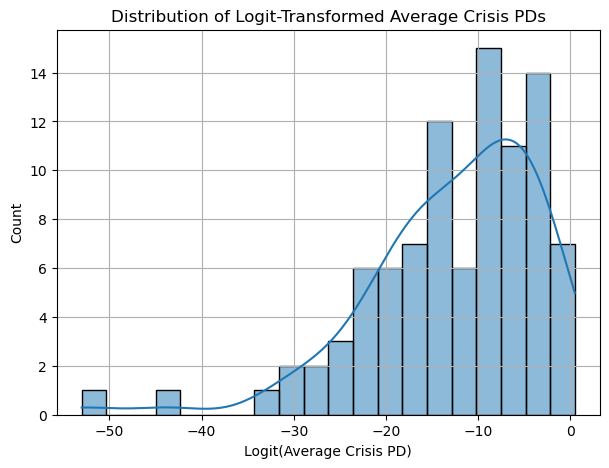

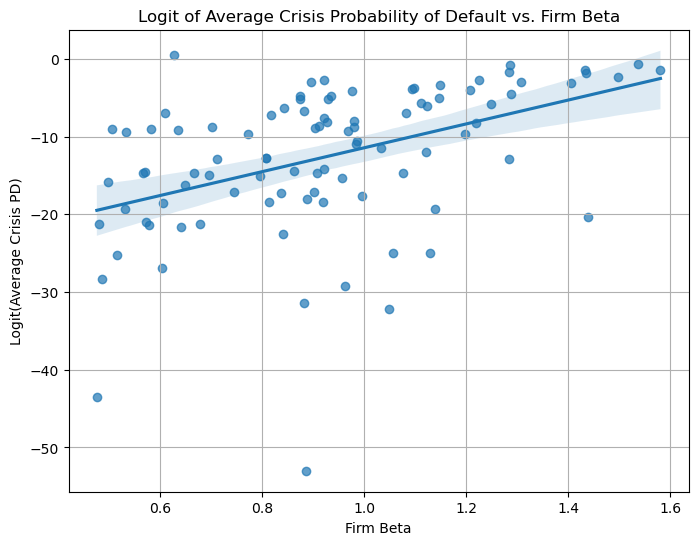

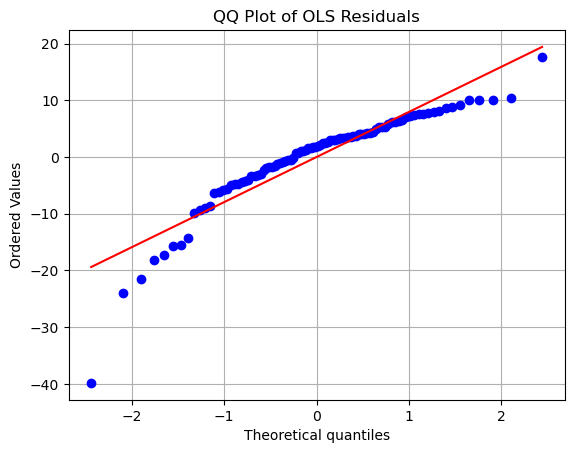

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

plt.figure(figsize=(7,5))
sns.histplot(merged['logit_avg_crisis_pd'], bins=20, kde=True)
plt.title('Distribution of Logit-Transformed Average Crisis PDs')
plt.xlabel('Logit(Average Crisis PD)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
sns.regplot(x='beta', y='logit_avg_crisis_pd', data=merged, ci=95, scatter_kws={'alpha':0.7})
plt.title('Logit of Average Crisis Probability of Default vs. Firm Beta')
plt.xlabel('Firm Beta')
plt.ylabel('Logit(Average Crisis PD)')
plt.grid(True)
plt.show()


residuals = model.resid
# QQ plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of OLS Residuals')
plt.grid(True)
plt.show()